# Fig. 3/4
- This experiment tests whether the anchoring of the HD cell bumps to visual landmarks can be disrupted by symmetry in the visual scene.
- The experiment start with open-loop presentaiton of flashes.
- The scene with a single sun was presented, followed by the "double-sun" scene which was point-symmetric. Then the scene came back to having only one sun.
- The control group of fish only experienced the single sun scene.
- This notebook generates panels for **Fig. 3, 4** as well as **Extended Data Fig. 7**, and some panels in **Extended Data Fig. 1**.

In [1]:
# import packages
from utility import *
import numpy as np
from matplotlib import pyplot as plt
import colorcet as cc
from pathlib import Path
from scipy.stats import binned_statistic, circmean, kstest, uniform, wilcoxon, ranksums
from scipy.signal import convolve2d
import json
from tqdm import tqdm

C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [50]:
# parameters
R2_thresh = 0.15    # sinusoidal regression goodness-of-fit threshold
flash_thresh = 0.1  # for rejecting light responsive cells
n_heading_bin = 8   # for averaging cells with similar head direction tuning
n_offset_bin = 16   # for scene-bump offset
mask_name = 'rhombomere1'
n_bootstrap = 1000

empty_bin_thresh = 5    # reject fish with too many empty bins
amplitude_thersh = 0.4  # reject fish whose bump decayed too much
out_frac = 1/4  # "out-of-phase" fraction

In [3]:
# config matplotlib
config_rcparams()

In [7]:
# get a list of fish
treatment_fish_list = get_fish_list('../data/main03/treatment', silent=True)
control_fish_list = get_fish_list('../data/main03/control', silent=True)

# Analysis
## Data extraction and ROI selection
- by design I can only do one recording per fish so there is no fish -> recording hierarchy here

In [9]:
cond = []
data = []

for j, fish_list in enumerate((treatment_fish_list, control_fish_list)):
    
    # Go through all unique fish
    for fish_id, recording in enumerate(fish_list):
    
        # Load the latest mask
        mask_list = list(recording.glob('mask_'+mask_name+'*'))
        with open(mask_list[-1], 'r') as f:
            mask = json.load(f)

        #################
        ### Load data ###
        #################

        # load behavioral / imaging data
        s2p_data, t_i, exp = load_data(recording, cells_only=False)

        # pull out relevant data from dict
        roi_coords = s2p_data['coords']
        slog    = exp['stimulus']['log']
        t_s     = exp.stimulus_log['t'].to_numpy()

        # split scene orientation into exogenous and motor-driven
        theta = exp.stimulus_log['doublesuns_theta'].to_numpy()
        gtheta = exp.stimulus_log['doublesuns_goal_theta'].to_numpy()
        ftheta = exp.stimulus_log['doublesuns_fish_theta'].to_numpy() * exp.stimulus_log['doublesuns_start_theta_update'].to_numpy()
        ftheta[np.isnan(ftheta)] = 0

        # downsample
        theta_i = downsample_traces(t_s, theta, t_i)
        cumftheta_i = downsample_traces(t_s, np.cumsum(ftheta), t_i)
        extheta_i = downsample_traces(t_s, gtheta+np.cumsum(ftheta), t_i)
        
        # restrict rois by mask (do this before functional selection to reduce the time-consuming nonlinear curve fitting)
        in_mask = (roi_coords[:, 2] > mask['x0']) * (roi_coords[:, 2] < mask['x1']) * (roi_coords[:, 1] > mask['y0']) * (roi_coords[:, 1] < mask['y1'])
        traces = s2p_data['traces'][in_mask,:len(t_i)]
        roi_coords = roi_coords[in_mask, :]
        n_roi = traces.shape[0]

        # normalization and smoothing
        norm_traces = ((traces.T - np.median(traces, axis=1))/np.std(traces, axis=1)).T
        smoothed_traces = convolve2d(norm_traces, np.ones((1,5))/5, mode='same')

        #####################
        ### ROI selection ###
        #####################

        # Flash
        flash_duration = slog[1]['duration']*2
        flash_t_start = [epoch['t_start'] for epoch in slog[1:-2:2]] # first epoch is wait, last two epochs are sun-and-bars and darkness. 
        flash_corr = calc_snip_correlation(norm_traces, t_i, flash_t_start, flash_duration)

        # Sinusoidal regression (2nd half o
        is_valid_theta = (np.isnan(theta_i)==False) * split_time(t_i, slog[-3]['t_start'], slog[-3]['duration'])
        fit_param, _, R2 = fit_transform_sinusoid(smoothed_traces[:, is_valid_theta], theta_i[is_valid_theta])

        # do the selection
        good_fit = (R2 > R2_thresh) * (flash_corr < flash_thresh)
        print(recording, 'Found', np.sum(good_fit), 'good ROIs out of', n_roi )

        ### Save everything in a dictionary ###
        D = {'stack': s2p_data['anatomy_stack'][0,:,:],
             'slog': slog,
             't_s': t_s,
             'fish_theta': exp.stimulus_log['doublesuns_fish_theta'].to_numpy(),
             't_i': t_i,
             'theta_i': theta_i,
             'cumftheta_i': cumftheta_i,
             'extheta_i': extheta_i,
             'theta_update_spike': exp.stimulus_log['doublesuns_start_theta_update'].to_numpy(),
             'traces': smoothed_traces[good_fit, :],
             'fit_param': fit_param[good_fit,:],
             'coords': roi_coords[good_fit, :]}
        data.append(D)
        cond.append(j)

..\data\main03\treatment\20240503_f3_10b Found 25 good ROIs out of 153
..\data\main03\treatment\20240510_f0_18107gad_aHB_v10b Found 49 good ROIs out of 161
..\data\main03\treatment\20240510_f2_gad_ahb_v10b Found 15 good ROIs out of 143
..\data\main03\treatment\20240510_f4_18107gad_ahb_v10b Found 0 good ROIs out of 126
..\data\main03\treatment\20240510_f5_gad_v10b_copy Found 0 good ROIs out of 169
..\data\main03\treatment\20240527_f0_10b Found 56 good ROIs out of 130
..\data\main03\treatment\20240527_f1_10b Found 104 good ROIs out of 176
..\data\main03\treatment\20240527_f2_10b Found 46 good ROIs out of 194
..\data\main03\treatment\20240527_f3_10b Found 19 good ROIs out of 121
..\data\main03\treatment\20240527_f4_10b Found 58 good ROIs out of 206
..\data\main03\treatment\20240527_f5_10b Found 38 good ROIs out of 152
..\data\main03\treatment\20240528_f0_v10b Found 106 good ROIs out of 205
..\data\main03\treatment\20240528_f1_v10b Found 58 good ROIs out of 140
..\data\main03\treatment\202

## Additional preprocessing
- calculate bump phase
- calculate offsets
- calculate amplitude ratios (to reject unreliable recordings)

In [10]:
bad_fish = []

# for offset histograms
offset_bin_edges = np.linspace(-np.pi, np.pi, n_offset_bin+1)
offset_bin_center = (offset_bin_edges[:-1] + offset_bin_edges[1:])/2

for i, D in enumerate(data):
    
    # epoch definition
    t_i = D['t_i']
    is_training = split_time(t_i, slog[-3]['t_start'], slog[-3]['duration'], is_train=True)
    is_pre      = split_time(t_i, slog[-3]['t_start'], slog[-3]['duration'], is_train=False)
    is_learn    = (t_i>slog[-2]['t_start']) * (t_i<slog[-1]['t_start'])
    is_post     = (t_i>slog[-1]['t_start'])
    data[i]['epochs'] = (is_training, is_pre, is_learn, is_post)

    # PVA calculation
    pva_theta, pva_length, binned_traces, _, _ = calc_binned_pva(D['traces'], D['fit_param'][:,1], n_bin=n_heading_bin)
    data[i]['pva_theta'] = pva_theta
    data[i]['pva_length'] = pva_length
    data[i]['binned_traces'] = binned_traces

    # bin check
    n_empty_bins = np.sum(np.isnan(binned_traces[:, 0]))
    
    # amplitude check
    amp_ratio = np.mean(pva_length[is_post])/np.mean(pva_length[is_training])
 
    # discard bad recordings with too many empty bins and too much bump decay
    if not (n_empty_bins < empty_bin_thresh) or (amp_ratio < amplitude_thersh):
        bad_fish.append(i)
        continue
        
    # offset quantification
    bump_scene_offset = angular_diff(D['theta_i'], D['pva_theta'])
    data[i]['bump_scene_offset'] = bump_scene_offset
    data[i]['offset_hists'] = [np.histogram(bump_scene_offset[epoch], bins=offset_bin_edges, density=True)[0] for epoch in (is_pre, is_learn, is_post)]
    data[i]['hist_fit'] = [curve_fit(von_Mises, offset_bin_center, hist, bounds=([-np.pi,0], [np.pi,np.inf]))[0] for hist in data[i]['offset_hists']]
    data[i]['out_ratios'] = [np.mean(np.abs(bump_scene_offset[epoch]) > (1-out_frac)*np.pi) for epoch in (is_pre, is_learn, is_post)]
    
    # document mean corrleation between anti-phase bins during the double sun presentation
    data[i]['min_anti_bin_corr'] = np.nanmin([np.corrcoef(binned_traces[:, is_learn])[i, i+4] for i in range(4)])

C:\Users\ryosuke\Documents\manuscripts\landmark\code_public\notebooks\utility.py:221: RuntimeWarning: invalid value encountered in divide
  PVA /= len(np.unique(phi_ind))


In [11]:
# pop bad recs from big ones
for i in bad_fish[::-1]:
    print('popping fish {}'.format(i))
    data.pop(i)
    cond.pop(i)

popping fish 52
popping fish 46
popping fish 42
popping fish 41
popping fish 38
popping fish 34
popping fish 17
popping fish 4
popping fish 3


# Panels
## Fig. 3c (example fish from the double sun condition)

In [12]:
# pick an example
fid = 24
D = data[fid]

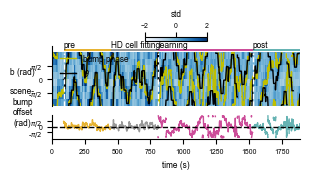

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(3.2,1.5), height_ratios=(5,2))

# pull out relevant timestamps
t_pre   = D['slog'][-3]['t_start']
t_learn = D['slog'][-2]['t_start']
t_post  = D['slog'][-1]['t_start']
t_end = max(D['t_i'])

## Neural time trace
im = ax[0].imshow(D['binned_traces'][::-1, :], aspect='auto', interpolation='nearest', vmax=2, vmin=-2, extent=(0, max(D['t_i']), -np.pi, np.pi), cmap='Blues')
ax[0].plot(D['t_i'], wrapped(np.unwrap(D['pva_theta']), offset=np.pi), 'y-', linewidth=1, label='bump phase')
ax[0].plot(D['t_i'], wrapped(D['theta_i'], offset=np.pi), 'k-', linewidth=1, label=r'$\theta$')
ax[0].legend()
cnames = ('pre', 'HD cell fitting','learning','post')
key_t = (t_pre, t_pre+D['slog'][-3]['duration']/2, t_learn, t_post, t_end)

# indicate epochs
for i, j in enumerate((5,1,6,7)): # doing this for color getter
    if i!=1:
        ax[0].plot((key_t[i], key_t[i]),(-np.pi,np.pi),'w--')
    ax[0].fill_between((key_t[i], key_t[i+1]), (np.pi+0.2, np.pi+0.2), (np.pi+0.4, np.pi+0.4), facecolor=color_getter(j), edgecolor='none')
    ax[0].text(key_t[i], np.pi+0.6, cnames[i])
    
ax[0].set_ylabel('b (rad)', rotation=0)
ax[0].set_yticks([-np.pi/2, 0, np.pi/2])
ax[0].set_yticklabels((r'-$\pi/2$', '0', r'$\pi/2$'))
cb = plt.colorbar(im, ax=ax, shrink=0.25, location='top')
cb.set_label('std')
toggle_spines(ax[0],0,0,0,1)

## Visualize offset
for i, j in enumerate((5,1,6,7)): # doing this for color getter
    this_range = (D['t_i']>key_t[i]) * (D['t_i']<key_t[i+1])
    ax[1].plot(D['t_i'][this_range], wrapped(D['bump_scene_offset'][this_range]), color=color_getter(j))
ax[1].plot((0, t_end), (0,0), 'k--')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('scene-\nbump\noffset\n(rad)', rotation=0)
ax[1].set_yticks([-np.pi/2, 0, np.pi/2])
ax[1].set_yticklabels((r'-$\pi/2$', '0', r'$\pi/2$'))
toggle_spines(ax[1],0,1,0,1)

for axx in ax:
    axx.set_xlim(0, t_end)

plt.savefig('../svg/main03_c.svg')
plt.show()

## Fig. 2d (scene-bump offset histogram by condition)

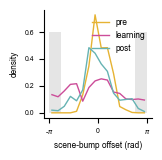

In [15]:
fig, ax = plt.subplots(figsize=(1.4, 1.4))

xtl = ['-$\pi$', '0','$\pi$']

# indicate out-phase range
ax.fill_between([-np.pi, (out_frac-1)*np.pi],[0,0],[0.6,0.6],facecolor='black',edgecolor='none',alpha=0.1)
ax.fill_between([(1-out_frac)*np.pi, np.pi],[0,0],[0.6,0.6],facecolor='black',edgecolor='none',alpha=0.1)

# loop over conditions
for i, temp in enumerate(zip((0,2,3), (5,6,7))):
    j, k = temp
    ax.plot(offset_bin_center, D['offset_hists'][i], color=color_getter(k), label=cnames[j])
ax.set_xlabel('scene-bump offset (rad)')
ax.set_ylabel('density')

ax.set_xticks(np.arange(-1,1.5,1)*np.pi)
ax.set_xticklabels(xtl)

ax.legend()
toggle_spines(ax,0,1,0,1)

plt.savefig('../svg/main03_d.svg')
plt.show()

## Fig. 2e (Out-phase ratio visualization)

In [17]:
## compile data
out_ratios = np.vstack([D['out_ratios'] for D in data])
cond = np.asarray(cond)

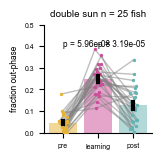

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(1.4,1.4))

p = scatter_bar(out_ratios[cond==0, :].T, ax=ax, connect=True, color=color_getter((5,6,7)), condnames=('pre','learning','post'), s=2)
ax.text(0, 0.4, 'p = {:0.2e}'.format(p[0,1]))
ax.text(1, 0.4, 'p = {:0.2e}'.format(p[0,2]))
ax.set_title('double sun n = {} fish'.format(np.sum(cond==0)))
ax.set_ylim(0, 0.5)
ax.set_ylabel('fraction out-phase')
toggle_spines(ax, 0,1,0,1)

plt.savefig('../svg/main03_e.svg')
plt.show()

## Extended Data Fig. 7a (Minimum correlation bewteen opposite bins during the second epoch)
- make sure that the correlation structure was not abolished by the two suns

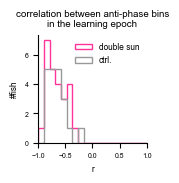

In [20]:
fig, ax = plt.subplots(1,1,figsize=(1.4, 1.4))
anti_bin_corr = np.asarray([D['min_anti_bin_corr'] for D in data])

ax.hist(anti_bin_corr[cond==0], bins=np.linspace(-1,1,20), color=color_getter(0), histtype='step', label='double sun')
ax.hist(anti_bin_corr[cond==1], bins=np.linspace(-1,1,20), color=color_getter(1), histtype='step', label='ctrl.')

# axis management
ax.legend()
ax.set_xlim([-1,1])
ax.set_ylabel('#fish')
ax.set_xlabel('r')
ax.set_title('correlation between anti-phase bins\nin the learning epoch')
toggle_spines(ax, 0,1,0,1)

plt.savefig('../svg/ed07_a.svg')
plt.show()

## Extended Data Fig. 7b (control fish example)

In [21]:
fid = 36
D = data[fid]

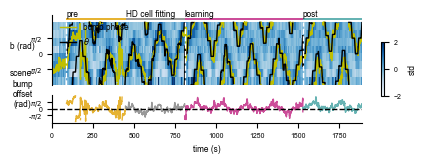

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(5,1.4), height_ratios=(5,2))

t_pre   = D['slog'][-3]['t_start']
t_learn = D['slog'][-2]['t_start']
t_post  = D['slog'][-1]['t_start']
t_end = max(D['t_i'])

## Neural time trace
im = ax[0].imshow(D['binned_traces'][::-1, :], aspect='auto', interpolation='nearest', vmax=2, vmin=-2, extent=(0, max(D['t_i']), -np.pi, np.pi), cmap='Blues')
ax[0].plot(D['t_i'], wrapped(np.unwrap(D['pva_theta']), offset=np.pi), 'y-', linewidth=1, label='bump phase')
ax[0].plot(D['t_i'], wrapped(D['theta_i'], offset=np.pi), 'k-', linewidth=1, label=r'$\theta$')
ax[0].legend()
cnames = ('pre', 'HD cell fitting','learning','post')
key_t = (t_pre, t_pre+D['slog'][-3]['duration']/2, t_learn, t_post, t_end)

# indicate epochs
for i, j in enumerate((5,1,6,7)): # doing this for color getter
    if i!=1:
        ax[0].plot((key_t[i], key_t[i]),(-np.pi,np.pi),'w--')
    ax[0].fill_between((key_t[i], key_t[i+1]), (np.pi+0.2, np.pi+0.2), (np.pi+0.4, np.pi+0.4), facecolor=color_getter(j), edgecolor='none')
    ax[0].text(key_t[i], np.pi+0.6, cnames[i])

ax[0].set_ylabel('b (rad)', rotation=0)
ax[0].set_yticks([-np.pi/2, 0, np.pi/2])
ax[0].set_yticklabels((r'-$\pi/2$', '0', r'$\pi/2$'))
cb = plt.colorbar(im, ax=ax, shrink=0.5)
cb.set_label('std')
toggle_spines(ax[0],0,0,0,1)

## Visualize offset
for i, j in enumerate((5,1,6,7)): # doing this for color getter
    this_range = (D['t_i']>key_t[i]) * (D['t_i']<key_t[i+1])
    ax[1].plot(D['t_i'][this_range], wrapped(D['bump_scene_offset'][this_range]), color=color_getter(j))
ax[1].plot((0, t_end), (0,0), 'k--')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('scene-\nbump\noffset\n(rad)', rotation=0)
ax[1].set_yticks([-np.pi/2, 0, np.pi/2])
ax[1].set_yticklabels((r'-$\pi/2$', '0', r'$\pi/2$'))
toggle_spines(ax[1],0,1,0,1)

for axx in ax:
    axx.set_xlim(0, t_end)

plt.savefig('../svg/ed07_b.svg')
plt.show()

## Extended Data Fig. 7c-e (Control fish scene-bump offset histogram + across group out-phase ratio comparison)

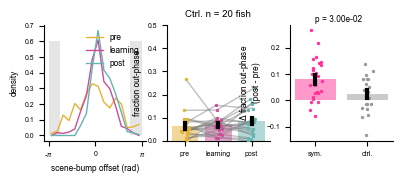

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(4.5, 1.5))

xtl = ['-$\pi$', '0','$\pi$']

# indicate out-phase range
ax[0].fill_between([-np.pi, (out_frac-1)*np.pi],[0,0],[0.6,0.6],facecolor='black',edgecolor='none',alpha=0.1)
ax[0].fill_between([(1-out_frac)*np.pi, np.pi],[0,0],[0.6,0.6],facecolor='black',edgecolor='none',alpha=0.1)

# plot offset histogram 
for i, temp in enumerate(zip((0,2,3), (5,6,7))):
    j, k = temp
    ax[0].plot(offset_bin_center, D['offset_hists'][i], color=color_getter(k), label=cnames[j])

# axis management
ax[0].set_xlabel('scene-bump offset (rad)')
ax[0].set_ylabel('density')
ax[0].set_xticks(np.arange(-1,1.5,1)*np.pi)
ax[0].set_xticklabels(xtl)
ax[0].legend()

# Out-phase range for control group
scatter_bar(out_ratios[cond==1, :].T, ax=ax[1], connect=True, color=color_getter((5,6,7)), condnames=('pre','learning','post'), s=2)
ax[1].set_ylim(0, 0.5)
ax[1].set_ylabel('fraction out-phase')
ax[1].set_title('Ctrl. n = {} fish'.format(np.sum(cond==1)))

# Across group comparison
p = scatter_bar([out_ratios[cond==i,2]-out_ratios[cond==i,0] for i in range(2)], condnames=('sym.', 'ctrl.'), ax=ax[2], color=color_getter((0,1)), s=2)
ax[2].set_ylabel('$\Delta$ fraction out-phase\n(post - pre)')
ax[2].text(0, 0.3, 'p = {:0.2e}'.format(p[0,1]))

for axx in ax:
    toggle_spines(axx, 0,1,0,1)

plt.savefig('../svg/ed07_cde.svg')
plt.show()

## Extended Data Fig. 1f (Behavior for double sun fish)

In [25]:
# Cut out snippets of exafferent rotation & cumulative turns

mean_snips = []

for i, D in enumerate(data):
    

    mean_snips.append([[],[],[]])
    
    for k in (-3, -2, -1): # for pre/learning/post epochs -- we don't do splitting because this is just behavior
        # find midpoints of exafferent rotations
        t_start = D['slog'][k]['t_start']
        duration = D['slog'][k]['duration']
        olp = D['slog'][k]['OLperiod']
        old = D['slog'][k]['OLduration']

        rotation_midpoints = [t_start + i*olp + (olp - old/2) for i in range(duration//olp-1)]

        theta_snip, snip_t = cut_snip(D['theta_i'],     D['t_i'], rotation_midpoints, 10, 10, subtract_pre=False)
        cumftheta_snip, _  = cut_snip(D['cumftheta_i'], D['t_i'], rotation_midpoints, 10, 10, subtract_pre=False)
        extheta_snip, _    = cut_snip(D['extheta_i'],   D['t_i'], rotation_midpoints, 10, 10, subtract_pre=False)

        theta_snip     -= theta_snip[:, 0][:, None]
        cumftheta_snip -= cumftheta_snip[:, 0][:, None]
        extheta_snip   -= extheta_snip[:, 0][:, None]

        # flipping 
        theta_snip     *= np.sign(extheta_snip[:, -1])[:, None]
        cumftheta_snip *= np.sign(extheta_snip[:, -1])[:, None]
        extheta_snip   *=np.sign(extheta_snip[:, -1])[:, None]
        
        # averaging over trials & registering
        mean_snips[-1][k] = (
            np.mean(theta_snip, axis=0),
            np.mean(cumftheta_snip, axis=0),
            np.mean(extheta_snip, axis=0)
        )
    
mean_snips = np.asarray(mean_snips)

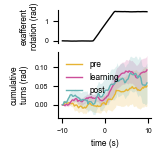

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(1.2,1.4), height_ratios=(1,2))

pop_mean_snips = np.nanmean(mean_snips[cond==0, ...], axis=0)
pop_sem_snips  = np.nanstd(mean_snips[cond==0, ...], axis=0) / np.sqrt(np.sum(cond==0))

# visualize stimulus
ax[0].plot(snip_t, np.mean(pop_mean_snips[:, 0, :], axis=0), color='black')

# visualize turning
for i, label in enumerate(('pre', 'learning', 'post')):
    ax[1].fill_between(snip_t,
                       pop_mean_snips[i, 1, :]-pop_sem_snips[i, 1, :],
                       pop_mean_snips[i, 1, :]+pop_sem_snips[i, 1, :],
                       alpha=0.2, color=color_getter(i+5), lw=0)
    ax[1].plot(snip_t, pop_mean_snips[i, 1, :], color=color_getter(i+5),label=label)

# axis management
ax[1].legend()
ax[0].set_ylabel('exafferent\nrotation (rad)')
ax[1].set_ylabel('cumulative\nturns (rad)')
ax[1].set_xlabel('time (s)')

toggle_spines(ax[0], 0,0,0,1)
toggle_spines(ax[1], 0,1,0,1)

plt.savefig('../svg/ed01_f.svg')
plt.show()

## Extended Data Fig. 7f (Scene-bump offset histogram by epoch, for all fish in both conditions)
- The bump-scene offset is not clearly bimodal, even during the two-sun period

In [28]:
all_hist = np.asarray([[D['offset_hists'][i] for D in data] for i in range(3)])

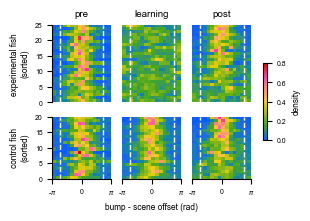

In [30]:
fig, ax = plt.subplots(2, 3, height_ratios=(np.sum(cond==0), np.sum(cond==1)), figsize=(3.2,2))

for i in range(2):
    this_hist = all_hist[:, cond==i, :]
    this_ol = out_ratios[cond==i, :][:, 2]
    sorted_this_hist = this_hist[:, np.argsort(this_ol), :]
    for j in range(3): # plot histogram as heatmap
        im = ax[i, j].imshow(sorted_this_hist[j, :], vmin=0, vmax=0.8, aspect='auto', interpolation='none',
                        cmap=cc.cm.CET_R3, extent=(-np.pi, np.pi, 0, np.sum(cond==i)))
        ax[i, j].plot( ((out_frac-1)*np.pi, (out_frac-1)*np.pi), (0,np.sum(cond==i)), 'w--', lw=1)
        ax[i, j].plot( ((1-out_frac)*np.pi, (1-out_frac)*np.pi), (0,np.sum(cond==i)), 'w--', lw=1)
        ax[i, j].set_xticks((-np.pi, 0, np.pi))
        ax[i, j].set_xticklabels(('-$\pi$','0','$\pi$'))

# axis management
ax[0, 0].set_ylabel('experimental fish\n(sorted)')
ax[1, 0].set_ylabel('control fish\n(sorted)')
ax[0, 0].set_title('pre')
ax[0, 1].set_title('learning')
ax[0, 2].set_title('post')
ax[1, 1].set_xlabel('bump - scene offset (rad)')

for i in range(2):
    for j in range(3):
        toggle_spines(ax[i,j],0,i==1,0,j==0)

cb = plt.colorbar(im, ax=ax, shrink=0.5)
cb.set_label('density')

plt.savefig('../svg/ed07_f.svg')
plt.show()

## Fig. 4a (Single cell tuning)
- Individual cells fire twice per cycle in the double sun scene
    - Across the population (N=25), "double sinusoid" explains the tuning in the double sun scene better than a single sinusoid
- Unexpectedly, tuning curves of HD neurons in the double sun scene gets shifted (in addition to being doubled) in the double sun scene, such that the anti-correlation is maintained

In [31]:
tuning_bin_edges = np.linspace(-np.pi, np.pi, n_offset_bin+1)
tuning_bin_center = (tuning_bin_edges[:-1] + tuning_bin_edges[1:])/2

# Go over the individual fish data again, and calculate, for each cell, HD tuning
for D in tqdm(data):

    sort_ind = np.argsort(D['fit_param'][:, 1])
    D['sorted_b'] = D['fit_param'][sort_ind, 1]
    indiv_tuning = []

    for y, b in zip(D['traces'], D['fit_param'][:,1]):
        indiv_tuning.append([
            binned_statistic(angular_diff(D['theta_i'][D['epochs'][i]], b), y[D['epochs'][i]], bins=tuning_bin_edges)[0]
            for i in range(4)
        ])
    indiv_tuning = np.asarray(indiv_tuning)[sort_ind, :, :]
    indiv_tuning -= np.min(indiv_tuning, axis=2)[:, :, None]
    indiv_tuning /= np.mean(indiv_tuning, axis=2)[:, :, None]
    
    D['indiv_tuning'] = indiv_tuning
    
    # fit single or double sinusoid of theta to each individual cell tuning curves
    single_fp, _, single_r2 = fit_transform_sinusoid(indiv_tuning[:, 2, :], tuning_bin_center)
    double_fp, _, double_r2 = fit_transform_sinusoid(indiv_tuning[:, 2, :], tuning_bin_center*2)
    
    D['learning_refit_param'] = np.hstack((single_fp, single_r2[:, None], double_fp, double_r2[:, None]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:17<00:00,  2.56it/s]


In [32]:
# average R2 of single/double sinusoidal fit within each fish
all_refit_r2 = np.vstack([np.mean(D['learning_refit_param'][:, (3,7)], axis=0) for D in data])

In [33]:
# Pick example fish and ROIs
fid = 24
rids = (40, 90, 15, 65)

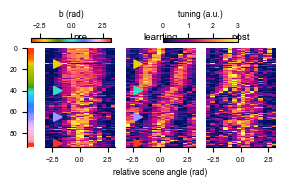

In [34]:
D = data[fid]
n_roi = D['fit_param'].shape[0]

fig, ax = plt.subplots(1, 4, figsize=(3.2,1.6), width_ratios=(0.1,1,1,1))

# plot individual ROI tuning as a heatmap, separately for each epoch
im0 = ax[0].imshow(D['sorted_b'][None, :].T, aspect='auto', cmap=cc.cm.CET_C6, vmin=-np.pi, vmax=np.pi, extent=(0, 1, n_roi, 0))
for i in range(3):
    im1 = ax[i+1].imshow(D['indiv_tuning'][:, i+1, :], 
                   aspect='auto', interpolation='none',
                   vmin=0, vmax=3, cmap=cc.cm.CET_L8, 
                   extent=(-np.pi, np.pi, n_roi, 0))
for i in range(4):
    toggle_spines(ax[i], 0, i>0, 0, i==0)
    
cb0 = plt.colorbar(im0, ax=ax[:2], location='top', shrink=1/1.1)
cb1 = plt.colorbar(im1, ax=ax[2:], location='top', shrink=0.5)

cb0.set_label('b (rad)')
cb1.set_label('tuning (a.u.)')

ax[2].set_xlabel('relative scene angle (rad)')
ax[1].set_title('pre')
ax[2].set_title('learning')
ax[3].set_title('post')

# label ROIs shown as an example
for i in (1,2):
    ax[i].scatter((-2,)*len(rids), rids, c=D['sorted_b'][np.asarray(rids)], marker='>', cmap=cc.cm.CET_C6, vmin=-np.pi, vmax=np.pi)

plt.savefig('../svg/main04_a.svg')
plt.show()

## Extended Data Fig. 7g (additional examples of single cell tuning)

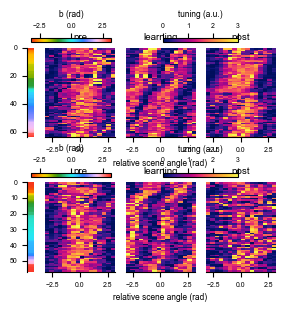

In [35]:
# additional examples
fids = (12, 11)
fig, axx = plt.subplots(len(fids), 4, figsize=(3.2,1.6*len(fids)), width_ratios=(0.1,1,1,1))

for ff, ax in zip(fids, axx):
    D = data[ff]
    n_roi = D['fit_param'].shape[0]

    im0 = ax[0].imshow(D['sorted_b'][None, :].T, aspect='auto', cmap=cc.cm.CET_C6, vmin=-np.pi, vmax=np.pi, extent=(0, 1, n_roi, 0))
    for i in range(3):
        im1 = ax[i+1].imshow(D['indiv_tuning'][:, i+1, :], 
                       aspect='auto', interpolation='none',
                       vmin=0, vmax=3, cmap=cc.cm.CET_L8, 
                       extent=(-np.pi, np.pi, n_roi, 0))
    for i in range(4):
        toggle_spines(ax[i], 0, i>0, 0, i==0)

    cb0 = plt.colorbar(im0, ax=ax[:2], location='top', shrink=1/1.1)
    cb1 = plt.colorbar(im1, ax=ax[2:], location='top', shrink=0.5)

    cb0.set_label('b (rad)')
    cb1.set_label('tuning (a.u.)')

    ax[2].set_xlabel('relative scene angle (rad)')

    ax[1].set_title('pre')
    ax[2].set_title('learning')
    ax[3].set_title('post')

plt.savefig('../svg/ed07_g.svg')
plt.show()

## Fig. 4b (compare single vs. double $\theta$ tuning goodness-of-fit)

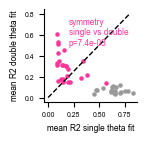

In [36]:
# Show that, on average, the HD neurons are firing twice per cycle in the symmetry condition, as expected
# despite the lack of the clear bimodality in population level bump / scene offsets

fig, ax = plt.subplots(1, 1, figsize=(1.2,1.2))
for i in range(2):
    ax.scatter(all_refit_r2[cond==i, 0], all_refit_r2[cond==i, 1], color=color_getter(i), s=5)
ax.plot((0,0.8),(0,0.8),'k--') # unity line

ax.text(0.2, 0.5, 'symmetry\nsingle vs double\np={:0.1e}'.format(wilcoxon(all_refit_r2[cond==0, 1]-all_refit_r2[cond==0, 0])[1]),
       color=color_getter(0))

ax.set_xlabel('mean R2 single theta fit')
ax.set_ylabel('mean R2 double theta fit')

toggle_spines(ax, 0,1,0,1)

plt.savefig('../svg/main04_b.svg')
plt.show()

## Fig. 4c (Polar visualization of individual cell tuning)
- Look at the same fish and cells as shown in panel a

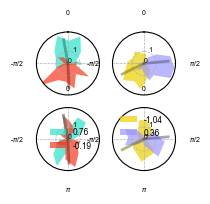

In [39]:
# polar visualization of example cell pair, which I think is more intuitive
fig, ax = plt.subplots(2, 2, figsize=(1.8, 1.8), subplot_kw={'projection': 'polar'})
D = data[fid]
for j, rid in enumerate(rids):
    for i in range(2): # pre vs. double
        x = tuning_bin_center+D['sorted_b'][rid]
        y = D['indiv_tuning'][rid, i+1, :]
        remap_amount = D['learning_refit_param'][rid, 5]/2
        col = cc.cm.CET_C6((D['sorted_b'][rid]+np.pi)/(np.pi*2))
        darkcol = [cc/2 for cc in col]
        ax[i, j//2].fill_between(polar_wrap(x), 0, polar_wrap(y), 
                                 lw=0, alpha=0.7, label='{:0.2f}'.format(remap_amount),
                                 color=col)
        ax[i, j//2].plot((D['sorted_b'][rid],)*2, (0,2), lw=2,
                         color=darkcol)

# axis management
for axx in ax:
    for axxx in axx:
        axxx.set_theta_zero_location("N")  # theta=0 at the top
        axxx.set_theta_direction(-1)
        axxx.set_rticks([0, 1])
        axxx.set_thetagrids((0,90,180,270) , ('0', '$\pi$/2' , '$\pi$', '-$\pi$/2'))
        axxx.grid(lw=0.5, linestyle='--', zorder=-5)
        axxx.set_rlim((0,2.6))
ax[1, 0].legend()
ax[1, 1].legend()

plt.savefig('../svg/main04_c.svg')
plt.show()

## Fig. 4d (compare differnece in preferred heading and difference in preferred heading change in the symmetric scene)

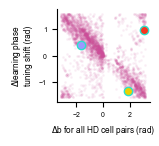

In [40]:
# Show that the tuning difference in the single sun scene is related to
# the amount of tuning shift in the double sun scene

c = cond[fid]
b_diff = angular_diff(D['sorted_b'][:, None] , D['sorted_b'][None, :]) # take difference of b for all pairs of ROIs
new_b = D['learning_refit_param'][:, 5] # "preferred angle" in double-theta fit
new_b_diff = angular_diff(new_b[:, None] , new_b[None, :])/2
unique_pair = np.triu(np.ones(b_diff.shape), 1)==1

fig, ax = plt.subplots(1, 1, figsize=(1.2, 1.2))
plt.scatter(b_diff[unique_pair], new_b_diff[unique_pair],s=3, alpha=0.1, color=color_getter(6),  lw=0,)
ax.set_xlabel('$\Delta$b for all HD cell pairs (rad)')
ax.set_ylabel('$\Delta$learning phase\ntuning shift (rad)')

# show where the examples sit
for k in (1,2,3):
    plt.scatter(b_diff[rids[0], rids[k]], new_b_diff[rids[0], rids[k]], 
               color=cc.cm.CET_C6((D['sorted_b'][rids[k]]+np.pi)/(np.pi*2)),
               marker='o', edgecolors=cc.cm.CET_C6((D['sorted_b'][rids[0]]+np.pi)/(np.pi*2)))

toggle_spines(ax,0,1,0,1)

plt.savefig('../svg/main04_d.svg')
plt.show()

## Fig. 4e, f ($\Delta$b vs. $\Delta$tuning shift comparison as a population)

In [41]:
# Bin delta tuning shift by delta b
binned_delta_tuning = []
for D in data:
    b_diff = angular_diff(D['sorted_b'][:, None] , D['sorted_b'][None, :])
    new_b  = D['learning_refit_param'][:, 5]
    new_b_diff = angular_diff(new_b[:, None] , new_b[None, :])
    unique_pair = np.triu(np.ones(b_diff.shape), 1)==1
    binned_delta_tuning.append(
        binned_statistic(b_diff[unique_pair],
                         new_b_diff[unique_pair],
                         bins=offset_bin_edges,
                         statistic=lambda x:circmean(x,low=-np.pi, high=np.pi))[0]
    )
binned_delta_tuning = np.asarray(binned_delta_tuning) / 2
mean_bdt = circmean(binned_delta_tuning[cond==0, :], axis=0, nan_policy='omit', low=-np.pi, high=np.pi)

# calculate slope
remap_slope = np.asarray([np.linalg.lstsq(offset_bin_center[np.isnan(bdt)==0, None],
                            bdt[np.isnan(bdt)==0,None])[0][0][0]
            for bdt in binned_delta_tuning])
mean_slope = np.linalg.lstsq(offset_bin_center[:,None], mean_bdt[:,None])[0][0][0]

C:\Users\ryosuke\AppData\Local\Temp\ipykernel_2904\3445839689.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  remap_slope = np.asarray([np.linalg.lstsq(offset_bin_center[np.isnan(bdt)==0, None],
C:\Users\ryosuke\AppData\Local\Temp\ipykernel_2904\3445839689.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  mean_slope = np.linalg.lstsq(offset_bin_center[:,None], mean_bdt[:,None])[0][0][0]


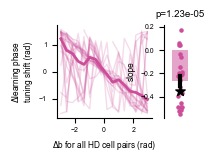

In [46]:
# Tuning difference and remapping maounts are linearly related at the ratio close to 0.5
# That is, antipodic HD cell pairs (with tunings 180 degrees apart) move their tuning (total) 90 degrees from each other in the double sun scene
# so as to remain anti-correlated

fig, ax = plt.subplots(1, 2, figsize=(1.8, 1.2), width_ratios=(3,1))

# binned delta-b vs. delta-tuning shift
ax[0].plot(offset_bin_center, binned_delta_tuning[cond==0, :].T, color=color_getter(6), alpha=0.2)
ax[0].plot(offset_bin_center, mean_bdt, color=color_getter(6), lw=2)

# Show slopes and compare against 0
scatter_bar(remap_slope[cond==0][None, :], ax=ax[1], s=5, color=[color_getter(6)])
ax[1].scatter(0, mean_slope, s=50, color='black', marker='*', zorder=5)

# axis management
ax[0].set_xlabel('$\Delta$b for all HD cell pairs (rad)')
ax[0].set_ylabel('$\Delta$learning phase\ntuning shift (rad)')
ax[1].set_ylabel('slope')
ax[1].set_xticks([])
ax[1].set_xlim(-0.8,0.8)
ax[1].set_title('p={:0.2e}'.format(wilcoxon(remap_slope[cond==0])[1]))
toggle_spines(ax[0],0,1,0,1)
toggle_spines(ax[1],0,0,0,1)

plt.savefig('../svg/main04_ef.svg')
plt.show()

## Fig. 4g (scene orientation vs. bump phase in each epoch)
- The fact that the anticorrelated pairs of the HD cells have tuning 90 degrees apart means, at the population level, that the 180 degrees of the visual space gets mapped onto the full 360 degrees of the HD cells
    - This explains why the bump-scene offset (assuming 1:1 mapping) never looked bimodal
- Scatter plot theta and bump to show this stretching clearly
- Fit von Mises on (2$\theta$ - bump phase), and run bootstrap test
    - Individual stats + KS test strategy

In [47]:
# pick the same example fish
fid = 24
D = data[fid]

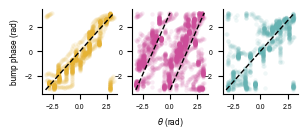

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(3.3, 1.1))

# plot bump vs theta, without taking difference
for i in range(3):
    inds = D['epochs'][i+1]
    this_scene = angular_diff(D['theta_i'][inds],0)
    this_bump = angular_diff(D['pva_theta'] [inds],0)
    ax[i].scatter(this_scene, this_bump, s=10, color=color_getter(i+5), alpha=0.1, lw=0)
    toggle_spines(ax[i], 0, 1, 0, 1)

ax[0].plot((-np.pi, np.pi), (-np.pi, np.pi), 'k--')
ax[1].plot((-np.pi, 0), (-np.pi, np.pi), 'k--')
ax[1].plot((0, np.pi), (-np.pi, np.pi), 'k--')
ax[2].plot((-np.pi, np.pi), (-np.pi, np.pi), 'k--')

ax[0].set_ylabel(r'bump phase (rad)')
ax[1].set_xlabel(r'$\theta$ (rad)')

plt.savefig('../svg/main04_g.svg')
plt.show()

## Fig. 4h ($2\theta$-bump offset histogram from the example fish)

In [51]:
# do the bootstrap test on von Mises fit on 2theta-bump offset

for D in data:
    # calculate histogram of bump vs. 2theta offset
    offset_2theta = angular_diff(D['theta_i']*2, D['pva_theta'])
    hists = [np.histogram(offset_2theta[epoch], bins=offset_bin_edges, density=True)[0] for epoch in D['epochs'][1:]]
    
    # fit von Mises
    fits = []
    for this_hist in hists:
        fits.append(curve_fit(von_Mises, offset_bin_center, this_hist, bounds=([-np.pi,0], [np.pi,np.inf]))[0])
    fits = np.asarray(fits)
    kappas = fits[:, 1]
    
    # shift and recalculate kappa (only for the double sun epoch)
    is_ds = D['epochs'][2]
    shuffle_kappa = np.zeros(n_bootstrap)
    for b in tqdm(range(n_bootstrap)):
        # shift theta and bump by a random amount, recalculate offset, fit von Mises again
        shuffled_offset = angular_diff(D['theta_i'][is_ds]*2, np.roll(D['pva_theta'][is_ds], np.random.randint(np.sum(is_ds))))
        shuffled_hist = np.histogram(shuffled_offset, bins=offset_bin_edges, density=True)[0]
        shuffled_fit, _ = curve_fit(von_Mises, offset_bin_center, shuffled_hist, bounds=([-np.pi,0], [np.pi,np.inf]))
        shuffle_kappa[b] = shuffled_fit[1]
    
    D['offset_hists_2theta'] = hists
    D['offset_2theta_fit_param'] = fits
    D['bs_med_2theta_kappa'] = np.median(shuffle_kappa, axis=0)
    D['bs_95pt_2theta_kappa'] = np.percentile(shuffle_kappa, 95, axis=0)
    D['p_2theta_kappa'] = np.mean(shuffle_kappa > kappas[1], axis=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.01it/s]


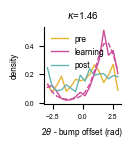

In [52]:
D = data[fid]
fig, ax = plt.subplots(figsize=(1, 1))

for i, cname in enumerate(('pre', 'learning', 'post')):
    ax.plot(offset_bin_center, D['offset_hists_2theta'][i], color=color_getter(i+5), label=cname)
ax.plot(offset_bin_center, von_Mises(offset_bin_center, *D['offset_2theta_fit_param'][1, :]), '--', color=color_getter(6))
ax.set_title('$\kappa$={:0.2f}'.format(D['offset_2theta_fit_param'][1,1]))
ax.set_xlabel(r'2$\theta$ - bump offset (rad)')
ax.set_ylabel('density')
ax.legend()
toggle_spines(ax, 0, 1, 0, 1)

plt.savefig('../svg/ed04_h.svg')
plt.show()

## Fig. 4i ($2\theta$ offset $\kappa$ with bootstrap distributions)

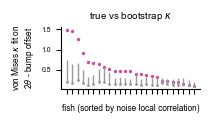

In [54]:
# visualize kappa vs. bootstrap, and show distribution
fig, ax = plt.subplots(1, 1, figsize=(1.8, 0.8))

# first, sort data
all_2t_kappa  = np.asarray([D['offset_2theta_fit_param'] for D in data])[cond==0, 1, 1] # fish x condition x {mu, kappa}
all_bs_med_2tk = np.asarray([D['bs_med_2theta_kappa'] for D in data])[cond==0]
all_bs_95pt_2tk = np.asarray([D['bs_95pt_2theta_kappa'] for D in data])[cond==0]

sort_ind = np.argsort(-all_2t_kappa)
xx = np.arange(np.sum(cond==0))

ax.scatter(xx, all_2t_kappa[sort_ind], s=2, color=color_getter(6))
ax.errorbar(xx, all_bs_med_2tk[sort_ind],
            np.vstack((xx*0, all_bs_95pt_2tk[sort_ind]-all_bs_med_2tk[sort_ind])),
            marker='.', color=color_getter(1), linestyle='none', markersize=2)

# cosmetics
ax.set_xticks(range(len(xx)))
ax.set_xticklabels([])
ax.set_xlabel('fish (sorted by noise local correlation)')
ax.set_title('true vs bootstrap $\kappa$')
ax.set_ylabel('von Mises $\kappa$ fit on\n'+r'2$\theta$ - bump offset')
toggle_spines(ax, 0, 1, 0, 1)

plt.savefig('../svg/main04_i.svg')
plt.show()

## Extended Data Fig. 7g (distribution of bootstrap p-values on von Mises fit on $2\theta$-bump offset)

In [55]:
# flatten p
all_p_2tk = np.asarray([D['p_2theta_kappa'] for D in data])[cond==0]

# calculate CDF
p_x = np.linspace(0,1,1000)
p_cdf = np.asarray([np.mean(all_p_2tk<x) for x in p_x])
ksp = kstest(all_p_2tk, uniform.cdf)[1]

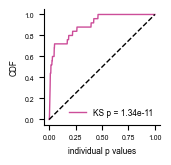

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))
ax.plot(p_x, p_cdf, color=color_getter(6), label='KS p = {:0.2e}'.format(ksp))
ax.plot(p_x, p_x, 'k--')
ax.legend()
ax.set_xlabel('individual p values')
ax.set_ylabel('CDF')
toggle_spines(ax, 0, 1, 0, 1)

plt.savefig('../svg/ed07_h.svg')
plt.show()